## Cafe Sales - Exploratory Data Analysis Project

### Project Overview

This project presents a complete end-to-end Exploratory Data Analysis (EDA) journey on the "Cafe Sales – Dirty Data" dataset. Built entirely in Jupyter Notebook, it follows a structured, professional approach to transform messy real-world data into clean, reliable, and insight-rich information.

Through a combination of data cleaning, feature engineering, visual storytelling, and statistical exploration, the goal is to uncover trends that can help optimize café operations, understand customer behavior, and support business decision-making.

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

### 1. Data Loading & Initial Overview

Load a CSV file then creating a dataframe

In [2]:
df = pd.read_csv('cafe_sales.csv')

The purpose of a initial data review is to quickly understand the structure of the data and identify any potential issues or areas worth exploring further.

In [3]:
df.head(10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5,4.0,20.0,Credit Card,NaN,2023-03-31
6,TXN_4433211,UNKNOWN,3,3.0,9.0,ERROR,Takeaway,2023-10-06
7,TXN_6699534,Sandwich,4,4.0,16.0,Cash,UNKNOWN,2023-10-28
8,TXN_4717867,NaN,5,3.0,15.0,NaN,Takeaway,2023-07-28
9,TXN_2064365,Sandwich,5,4.0,20.0,NaN,In-store,2023-12-31


Let's take a look at the shape of the dataset

In [4]:
print(f"The Number of Rows are {df.shape[0]}, and columns are {df.shape[1]}.")

The Number of Rows are 10000, and columns are 8.


Let's take a look at the columns and their data types using the detailed info function.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


Let's take a quick look at the missing values in each column to identify any data quality issues.

In [6]:
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [7]:
df.isna().sum().sum()

np.int64(6826)

In [8]:
df.duplicated().sum()

np.int64(0)

---

***Observation set 1***

- There are 10000 rows and 8 columns in the dataset.
- The data type of all columns is object.
- The columns in the datasets are - Transaction ID, Item, Quantity, Price Per Unit, Total Spent, Payment Method, Location, Transaction Date
- There are some values in the dataset that appear to be inconsistent or incorrect.
- There are a few missing values in the dataset, which we will read in detail and deal with later on in the notebook.
- No duplicate records were found in the dataset, ensuring each transaction entry is unique.

---
---

### 2. Data Cleaning and Preprocessing

Let's first check for any mismatched or inconsistent data and fix them before changing the column data types.

In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_') # to replace spaces with underscores and convert to lowercase

It appears there are mismatched values such as "EERROR" and "UNKNOWN" in the data. Let's correct them before moving forward.

In [10]:
column_wise_error = df.map(lambda x: str(x).upper() in ['ERROR', 'UNKNOWN']).sum()

print("Column-wise count of 'ERROR' or 'UNKNOWN':")
print(column_wise_error)

Column-wise count of 'ERROR' or 'UNKNOWN':
transaction_id        0
item                636
quantity            341
price_per_unit      354
total_spent         329
payment_method      599
location            696
transaction_date    301
dtype: int64


In [11]:
df = df.replace(['ERROR', 'UNKNOWN'], np.nan)  # replace 'ERROR' and 'UNKNOWN' with NaN

Let's convert each column to its appropriate data type to ensure accurate analysis.

In [12]:
df['quantity'] = df['quantity'].astype('Int64')  # retains NaN
df['price_per_unit'] = df['price_per_unit'].astype(float)
df['total_spent'] = df['total_spent'].astype(float)
df.dtypes

transaction_id       object
item                 object
quantity              Int64
price_per_unit      float64
total_spent         float64
payment_method       object
location             object
transaction_date     object
dtype: object

Now that the mismatched entries have been fixed, let's proceed with handling the missing values.

In [13]:
df.isnull().sum() # check for null values again

transaction_id         0
item                 969
quantity             479
price_per_unit       533
total_spent          502
payment_method      3178
location            3961
transaction_date     460
dtype: int64

Let's remove rows with more than 2 missing values to keep the dataset clean and reliable.

In [14]:
invalid_counts = df.isna().sum(axis=1)
df = df[invalid_counts <= 2]  # keep rows with 2 or fewer missing

print("Number of rows after removing rows with more than 2 NaN values:")
print(df.shape[0])


Number of rows after removing rows with more than 2 NaN values:
9510


Let's calculate percentage of NaN values in each column

In [15]:
df.isnull().mean() * 100 

transaction_id       0.000000
item                 7.886435
quantity             3.764458
price_per_unit       4.269190
total_spent          4.100946
payment_method      29.211356
location            37.234490
transaction_date     3.512093
dtype: float64

Let's address all missing values according to the nature and type of each column for accurate and consistent data cleaning.



Let's Impute Missing Categorical Values Using Mode

In [16]:
df['item'] = df['item'].fillna(df['item'].mode()[0]) 
df['location'] = df['location'].fillna(df['location'].mode()[0])
df['payment_method'] = df['payment_method'].fillna(df['payment_method'].mode()[0])

Let's Impute Missing quantity Values Using Mean

In [17]:
mean_value = round(df['quantity'].mean()) 
df['quantity'] = df['quantity'].fillna(mean_value) 

Let's Impute Missing price_per_unit Values Using Median

In [18]:
df['price_per_unit'] = df['price_per_unit'].fillna(df['price_per_unit'].median()) 

Let's Impute Missing 'total_spent' Values Using Linear Regression 
- *Missing values in 'total_spent' are predicted using a linear regression model with 'quantity' and 'price_per_unit' as input features.*

In [19]:
df_imputed = df.copy() # create a copy of the DataFrame for imputation

# Filter rows with and without missing 'total_spent'
df_reg_train = df_imputed[df_imputed['total_spent'].notnull()]
df_reg_missing = df_imputed[df_imputed['total_spent'].isnull()]

# Features and target
features = ['quantity', 'price_per_unit']
target = 'total_spent'

# Train linear regression model
reg = LinearRegression()
reg.fit(df_reg_train[features], df_reg_train[target])

# Predict missing total_spent
df_imputed.loc[df_imputed['total_spent'].isnull(), 'total_spent'] = reg.predict(df_reg_missing[features])

df_imputed['total_spent'] = df_imputed['total_spent'].round(1)  # Round total_spent to 2 decimal places

Let's Impute and Reconstruct Missing transaction_date Values

- *First, the transaction_date column is parsed into datetime format.*
- *Then, date components (year, month, day) are extracted and missing values are imputed using the median of each.*
- *Finally, a complete transaction_date is reconstructed from the filled parts, and the temporary helper columns are removed.*

In [20]:
# Impute transaction_date (parse date, extract parts, fill missing)

df_imputed['transaction_date'] = pd.to_datetime(df_imputed['transaction_date'], errors='coerce')

# Extract features
df_imputed['year'] = df_imputed['transaction_date'].dt.year
df_imputed['month'] = df_imputed['transaction_date'].dt.month
df_imputed['day'] = df_imputed['transaction_date'].dt.day

# Impute missing parts using median
for col in ['year', 'month', 'day']:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

df_imputed['transaction_date'] = pd.to_datetime(df_imputed[['year', 'month', 'day']].astype(int), errors='coerce')  # Reconstruct imputed transaction_date

df_imputed = df_imputed.drop(columns=['year', 'month', 'day'])  # Drop helper columns

Check for any remaining missing values and inspect the structure of the final imputed DataFrame to confirm it's ready for analysis.

In [21]:
df_imputed.isnull().sum()  

transaction_id      0
item                0
quantity            0
price_per_unit      0
total_spent         0
payment_method      0
location            0
transaction_date    0
dtype: int64

In [22]:
df = df_imputed.copy()  

Let's Detect Outliers Using the IQR Method

- *For each numerical column (quantity, price_per_unit, and total_spent), outliers are identified using the Interquartile Range (IQR) rule: values falling below Q1 − 1.5×IQR or above Q3 + 1.5×IQR are flagged as outliers.*

In [ ]:
num_cols = ['quantity', 'price_per_unit', 'total_spent']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {outliers.shape[0]} outliers")


quantity: 0 outliers
price_per_unit: 0 outliers
total_spent: 250 outliers


Let's Cap Outliers Using the IQR Method and Visualize the Impact

- *Outliers in each numerical column are detected using the IQR rule and capped at the lower and upper bounds.*
- *A new column is created to store the capped values, and side-by-side boxplots show the effect before and after capping.*

total_spent: 250 outliers capped


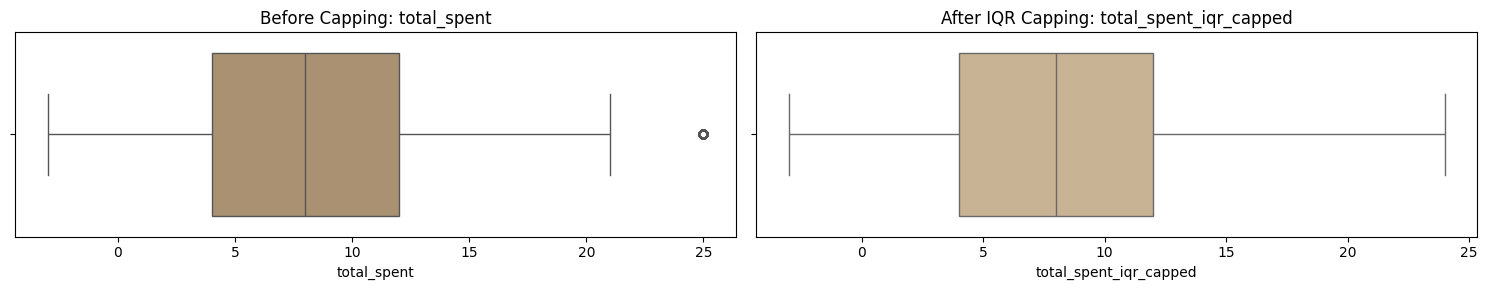

In [ ]:
col = 'total_spent' 

# Print how many outliers
print(f"{col}: {outliers.shape[0]} outliers capped")

# Cap and create new column
capped_col = f"{col}_iqr_capped"
df[capped_col] = df[col].clip(lower=lower, upper=upper)

# Plot before and after
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
sns.boxplot(x=df[col], ax=axes[0], color='#B29268')
axes[0].set_title(f"Before Capping: {col}")
sns.boxplot(x=df[capped_col], ax=axes[1], color='#D2B48C')
axes[1].set_title(f"After IQR Capping: {capped_col}")
plt.tight_layout()
plt.show()

df['total_spent'] = df[capped_col]  # Replace original column with capped values

- First, outliers were detected in all numerical columns. It was observed that quantity and price_per_unit had no outliers. However, total_spent contained clear outliers.
- To address the outliers in the total_spent column, the IQR capping method was applied.
Values beyond the lower and upper bounds based on IQR were replaced with the nearest acceptable limits to reduce the influence of extreme data points.
- Boxplots before and after capping clearly show the effect - 
    - The distribution became more compact.
    - Outliers were successfully eliminated.
    - The column is now better aligned for accurate analysis and modeling.

---

***Observation Set 2***

- There are mismatched values in the dataset, such as "EERROR" and "UNKNOWN", which were identified and corrected.
- All columns have been converted to their appropriate data types for consistency and proper analysis.
- Approximately 12.6% of the data was missing across various columns.
- Suitable techniques were applied to handle the missing values based on each column’s data type.
- Outliers were detected and capped using the IQR method, resulting in a cleaner dataset for further analysis.

---
---

### 3. Exploratory Data Analysis

Let's Perform Univariate Analysis on Numerical Features

- *Visualizing the distribution of quantity, price_per_unit, and total_spent using Histogram, KDE, and Boxplot to understand their shape, spread, and potential outliers.*

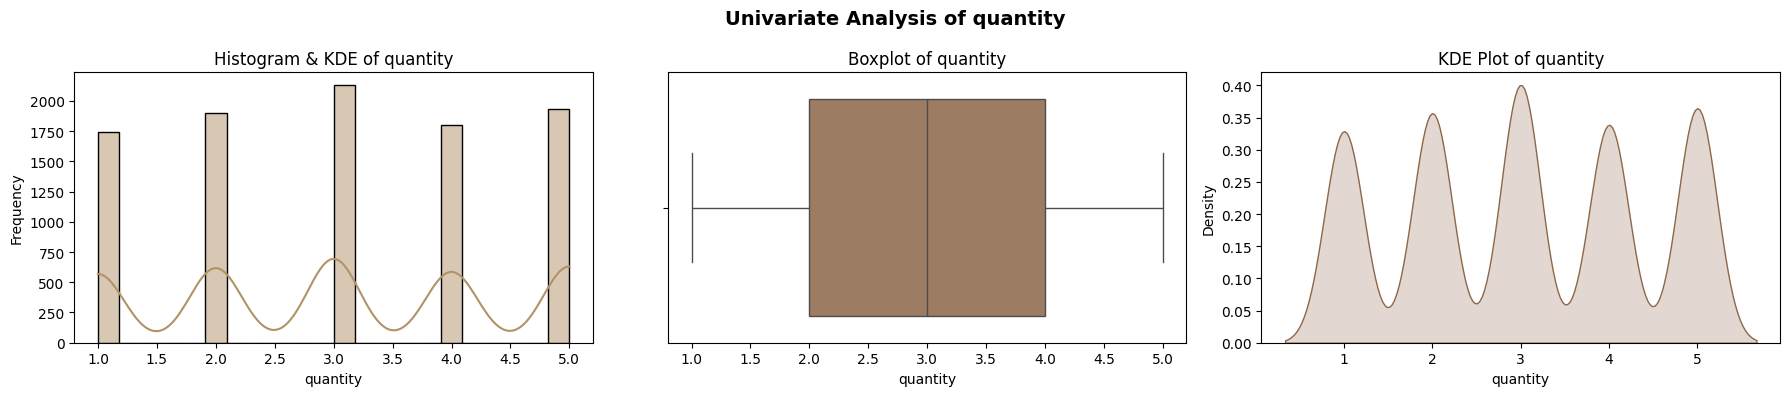

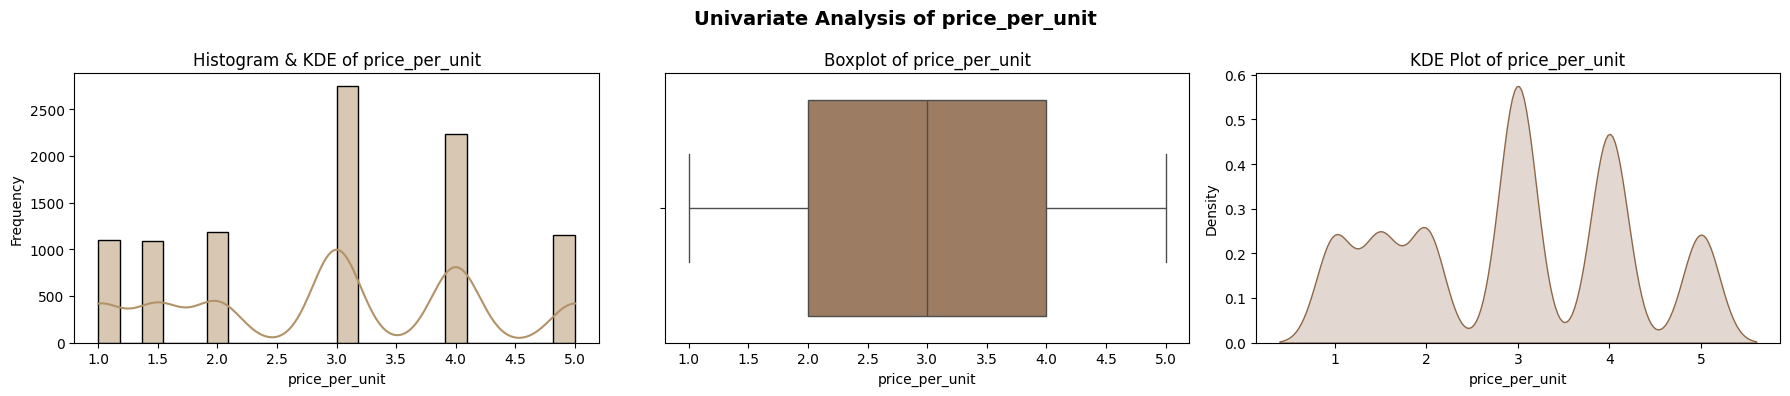

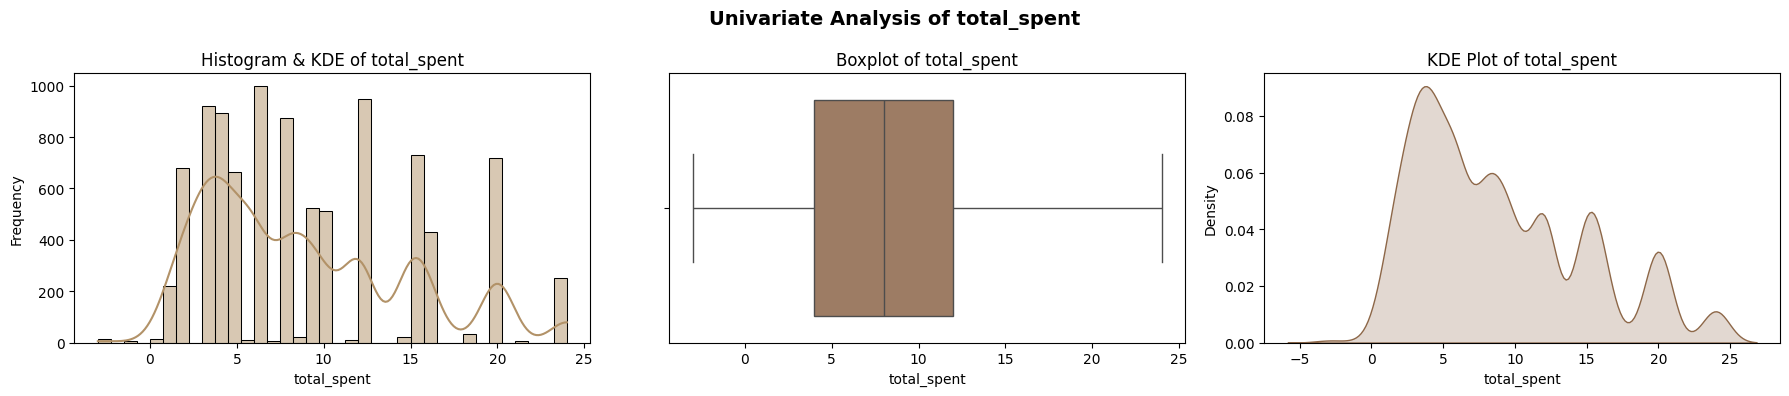

In [ ]:
num_cols = ['quantity', 'price_per_unit', 'total_spent']

for col in num_cols:
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Univariate Analysis of {col}', fontsize=14, fontweight='semibold')

    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axs[0], color='#B29268')
    axs[0].set_title(f'Histogram & KDE of {col}')
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=df[col], ax=axs[1], color='#A67B5B')
    axs[1].set_title(f'Boxplot of {col}')
    axs[1].set_xlabel(col)

    # KDE Plot separately
    sns.kdeplot(df[col], ax=axs[2], fill=True, color='#8D6748')
    axs[2].set_title(f'KDE Plot of {col}')
    axs[2].set_xlabel(col)
    axs[2].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

- Univariate analysis was performed on all numerical columns using histograms, KDE plots, and boxplots.
    - The quantity column showed a fairly even distribution with no noticeable skew or outliers.
    - The price_per_unit column appeared slightly right-skewed but remained within a reasonable range.
    - The total_spent column displayed a right-skewed distribution with visible outliers.
- These visualizations helped highlight key characteristics of the data - 
    - The shape and spread of each feature became more apparent.
    - Potential issues like skewness and outliers were identified early.
    - These insights guide necessary preprocessing before modeling.

Let's Perform Univariate Analysis on Categorical Features

- *Visualize the frequency distribution of item, payment_method, and location using count plots to identify category dominance and potential imbalances.*

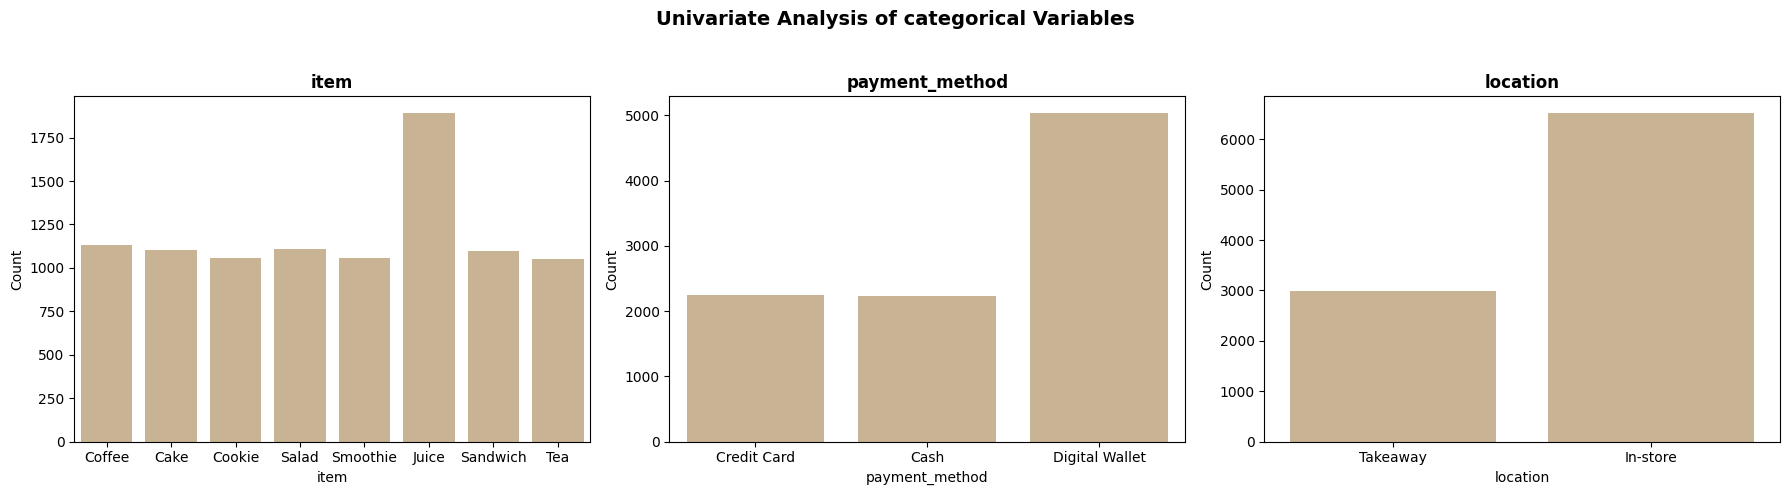

In [ ]:
cat_cols = ['item', 'payment_method', 'location']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'Univariate Analysis of categorical Variables', fontsize=14, fontweight='semibold')

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i], color='#D2B48C')
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

- The count plots reveal the most frequently occurring values in each categorical column.
    - item shows a strong preference toward certain products, indicating best-sellers.
    - payment_method distribution is uneven, suggesting a dominant payment type.
    - location counts are relatively balanced, but some branches may have higher activity.
- These patterns help understand customer behavior and operational dynamics.

Let's Perform Bivariate Analysis Across Variable Types
- *Explore relationships between pairs of variables using appropriate visualizations*

##### Numerical vs. Numerical

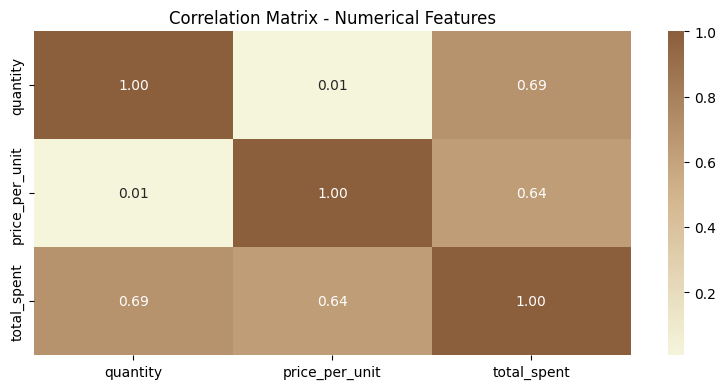

In [27]:
plt.figure(figsize=(8, 4))
tan_brown_cmap = LinearSegmentedColormap.from_list('tan_brown', ['#F5F5DC', '#D2B48C', '#8B5E3C'])

sns.heatmap(df[num_cols].corr(), annot=True, cmap=tan_brown_cmap, fmt=".2f")
plt.title("Correlation Matrix - Numerical Features")
plt.tight_layout()
plt.show()

- total_spent is strongly correlated with both quantity and price_per_unit, as expected.
- quantity and price_per_unit show a weak correlation, indicating they vary independently.
- Useful for understanding feature relationships and avoiding multicollinearity.

##### Categorical vs Numerical


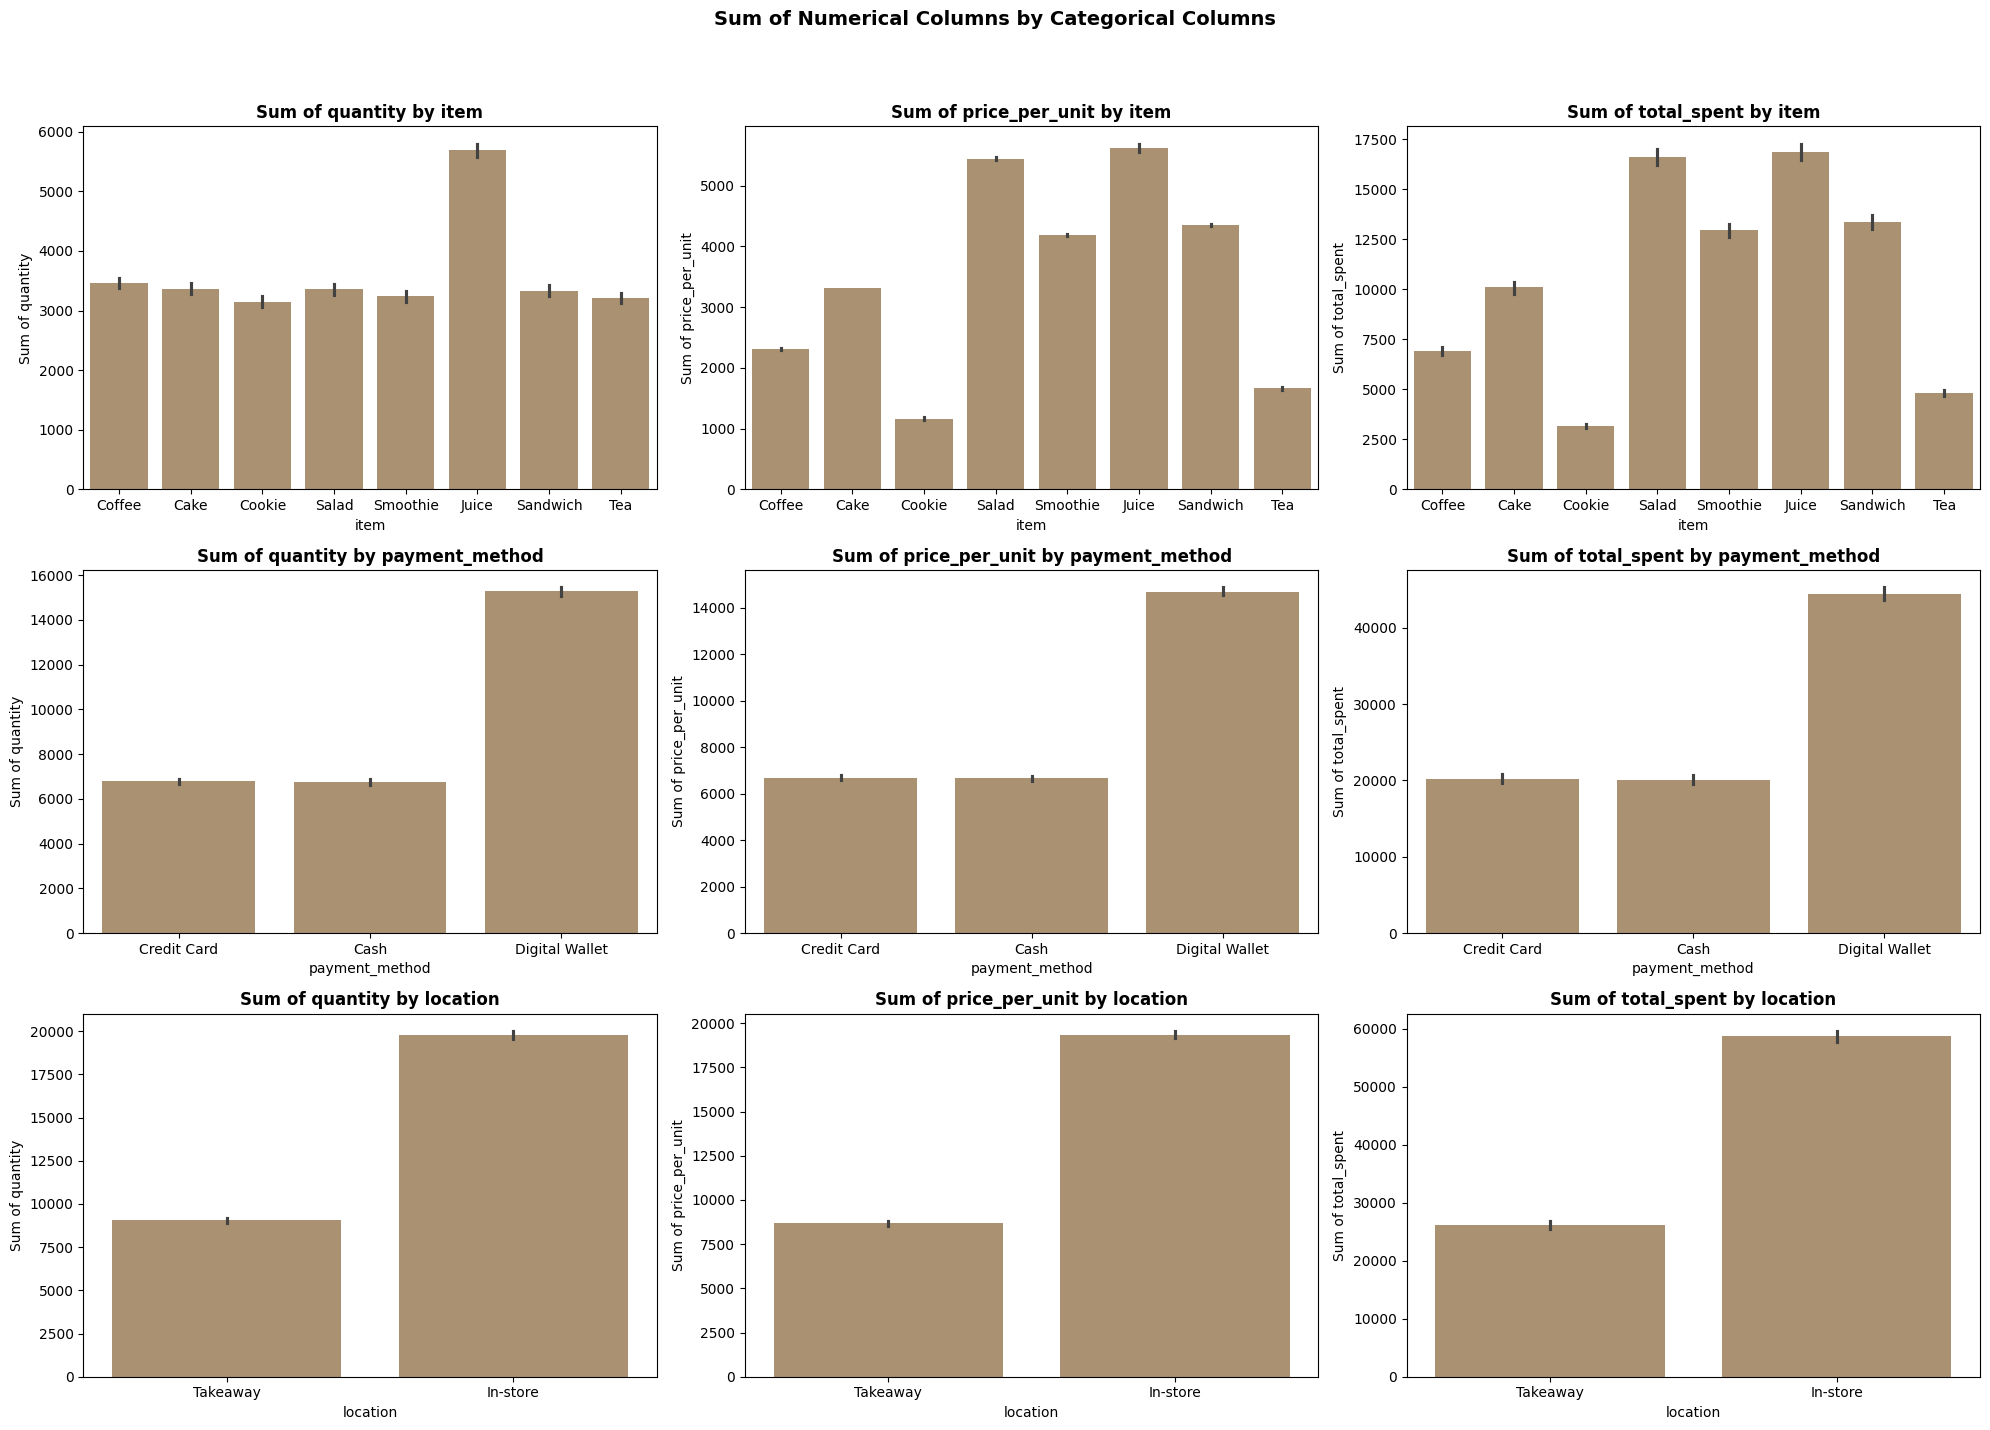

In [28]:
cat_cols = ['item', 'payment_method', 'location']
num_cols = ['quantity', 'price_per_unit', 'total_spent']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.suptitle('Sum of Numerical Columns by Categorical Columns', fontsize=14, fontweight='bold')

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each combination
plot_idx = 0
for cat in cat_cols:
    for num in num_cols:
        sns.barplot(data=df, x=cat, y=num, estimator='sum', color='#B29268', ax=axes[plot_idx])
        axes[plot_idx].set_title(f'Sum of {num} by {cat}', fontsize=12, fontweight='bold')
        axes[plot_idx].set_xlabel(cat)
        axes[plot_idx].set_ylabel(f'Sum of {num}')
        axes[plot_idx].tick_params(axis='x', rotation=0)
        plot_idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()

- This grid of bar plots provides insights into the distribution of total sales metrics across various categorical segments:

    - Some items consistently contribute more to overall sales and quantity sold.
    - Certain locations have higher total spending and may reflect busier or higher-priced branches.
    - The payment_method grouping shows which methods are linked to higher total purchase values.

- These aggregated views help identify key contributors to revenue and guide strategic decisions like stocking, promotions, and payment infrastructure.



##### Categorical vs Categorical


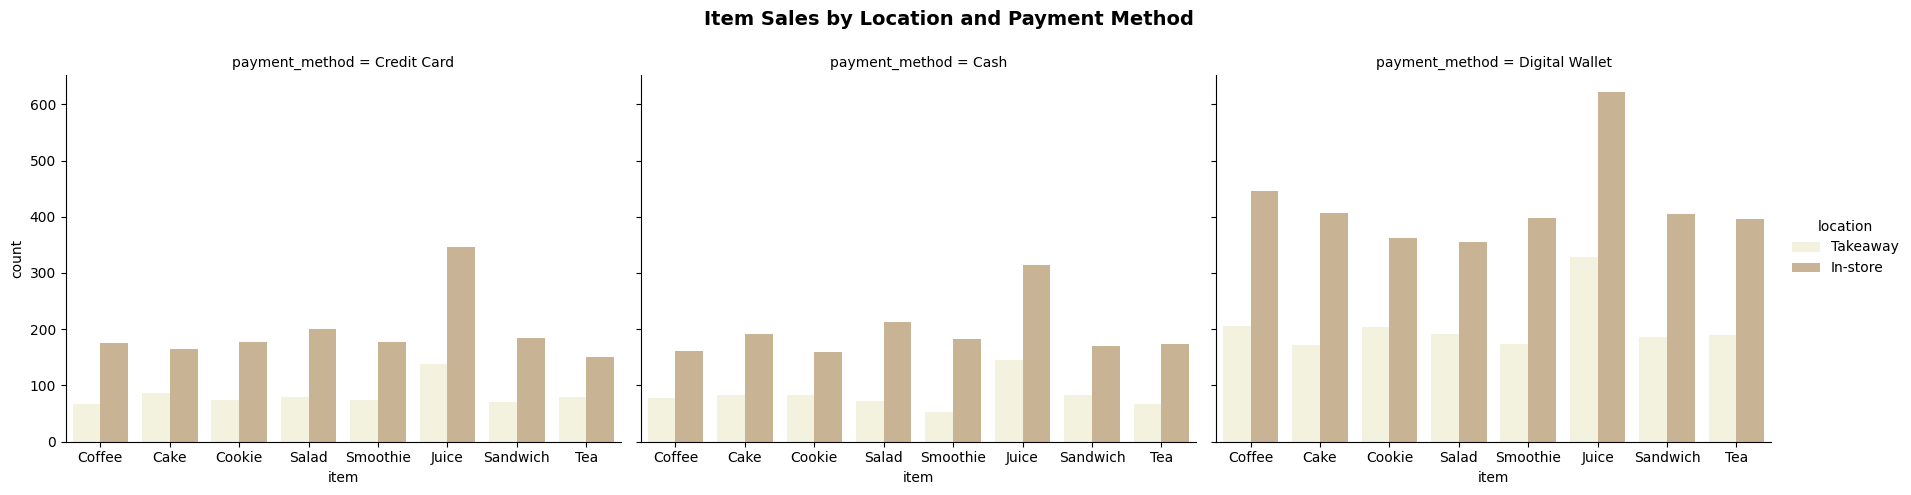

In [29]:
sns.catplot(
    data=df, 
    x='item', 
    hue='location', 
    col='payment_method', 
    kind='count', 
    height=5, 
    aspect=1.2,
    palette=['#F5F5DC', '#D2B48C']
)

plt.subplots_adjust(top=0.85)
plt.suptitle("Item Sales by Location and Payment Method", fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.show()

- This plot highlights the distribution of item sales segmented by location and further broken down by payment method. It helps identify - 

    - Location-specific item preferences
    - Payment trends across locations
    - Any patterns in how customers purchase specific items using particular payment methods

- Such insights are useful for optimizing inventory and enhancing customer experience across branches.

---

***Observation Set 3***

Univariate & Bivariate Analysis Summary
The univariate analysis revealed that quantity was evenly distributed, price_per_unit showed slight right skew, and total_spent had noticeable high-value outliers, which were capped using the IQR method. Among categorical features, a few items dominated sales, payment_method was heavily skewed toward one option, and location counts were relatively balanced with some high-traffic branches.

Bivariate analysis further uncovered strong positive correlations between total_spent, quantity, and price_per_unit. Visuals like stacked and grouped bar plots highlighted how item sales varied by location and payment method, and showed that certain items and branches contributed more significantly to revenue.

These insights help shape a clearer understanding of customer behavior, product performance, and branch-level differences—informing better operational and modeling strategies.

---
---

### 4. Feature Engineering

##### Feature Creation

Let's Create New Features to Extract Deeper Insights
- *Deriving meaningful features can help reveal hidden patterns and improve the effectiveness of analysis and modeling.*

In [30]:
# Create new features from date
df['day'] = df['transaction_date'].dt.day
df['month'] = df['transaction_date'].dt.month
df['weekday'] = df['transaction_date'].dt.day_name()
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])

# Validate total spent from quantity × price_per_unit
df['total_price_check'] = df['quantity'] * df['price_per_unit']

# Preview the new columns
df[['transaction_date', 'day', 'month', 'weekday', 'is_weekend', 'quantity', 'price_per_unit', 'total_price_check', 'total_spent']].head(10)

,transaction_date,day,month,weekday,is_weekend,quantity,price_per_unit,total_price_check,total_spent
0,2023-09-08,8,9,Friday,False,2,2.0,4.0,4.0
1,2023-05-16,16,5,Tuesday,False,4,3.0,12.0,12.0
2,2023-07-19,19,7,Wednesday,False,4,1.0,4.0,5.9
3,2023-04-27,27,4,Thursday,False,2,5.0,10.0,10.0
4,2023-06-11,11,6,Sunday,True,2,2.0,4.0,4.0
5,2023-03-31,31,3,Friday,False,5,4.0,20.0,20.0
6,2023-10-06,6,10,Friday,False,3,3.0,9.0,9.0
7,2023-10-28,28,10,Saturday,True,4,4.0,16.0,16.0
8,2023-07-28,28,7,Friday,False,5,3.0,15.0,15.0
9,2023-12-31,31,12,Sunday,True,5,4.0,20.0,20.0


- New date-based and validation features were created to enhance temporal analysis and verify the accuracy of the total_spent column.

In [31]:
df['total_spent'] = df['total_price_check'].round(1)  # Update total_spent with calculated values

- During feature creation, it was observed that total_spent and total_price_check (calculated as quantity × price_per_unit) did not perfectly match. To ensure accuracy, the calculated total_price_check was used as the reliable version of total_spent.

##### Feature Transformation

Let's Visualize and Prepare Skewed Numeric Features for Transformation
- *We'll examine the distribution of quantity, total_spent, and price_per_unit to identify skewness before applying transformations like log scaling or binning.*

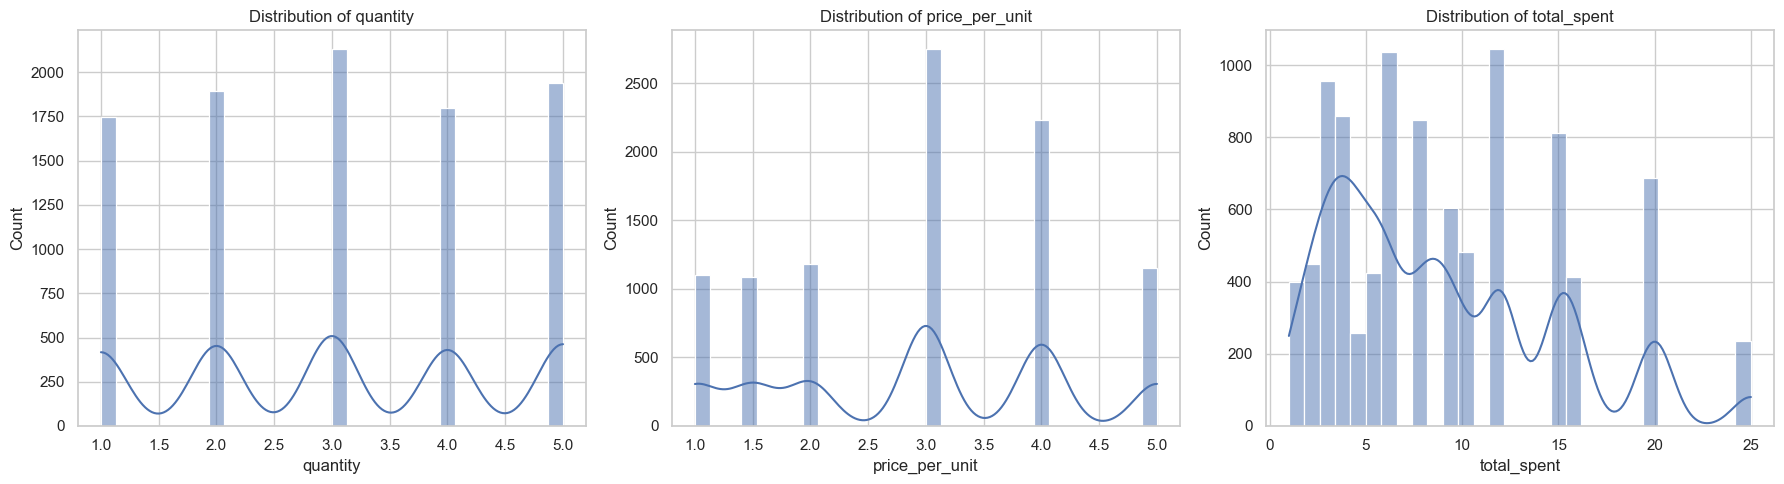

In [32]:
sns.set(style="whitegrid")

numeric_cols = ['quantity', 'price_per_unit', 'total_spent'] 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

- quantity – Right-skewed
    - Most transactions involve a smaller number of items (1–2 units), with fewer purchases involving higher quantities.
    - Interpretation: Customers generally buy in smaller amounts, possibly for daily or need-based consumption.

- price_per_unit – Multimodal discrete distribution
    - Prices are clustered around specific points ($1 to $5), with $3 being the most frequent.
    - Interpretation: Reflects a tiered pricing structure; $3 products may be bestsellers or standard-priced items.

- total_spent – Right-skewed with high-value outliers
    - Majority of customers spend under $10, but a few transactions reach much higher totals ($20+).
    - Interpretation: Indicates a typical pattern where a small segment of customers drive high revenue — potential targets for premium offers or loyalty strategies.

Let's Apply Log Transformation to Skewed Numeric Features
- *Used log1p to transform quantity, price_per_unit, and total_spent to reduce skewness and bring distributions closer to normal.*

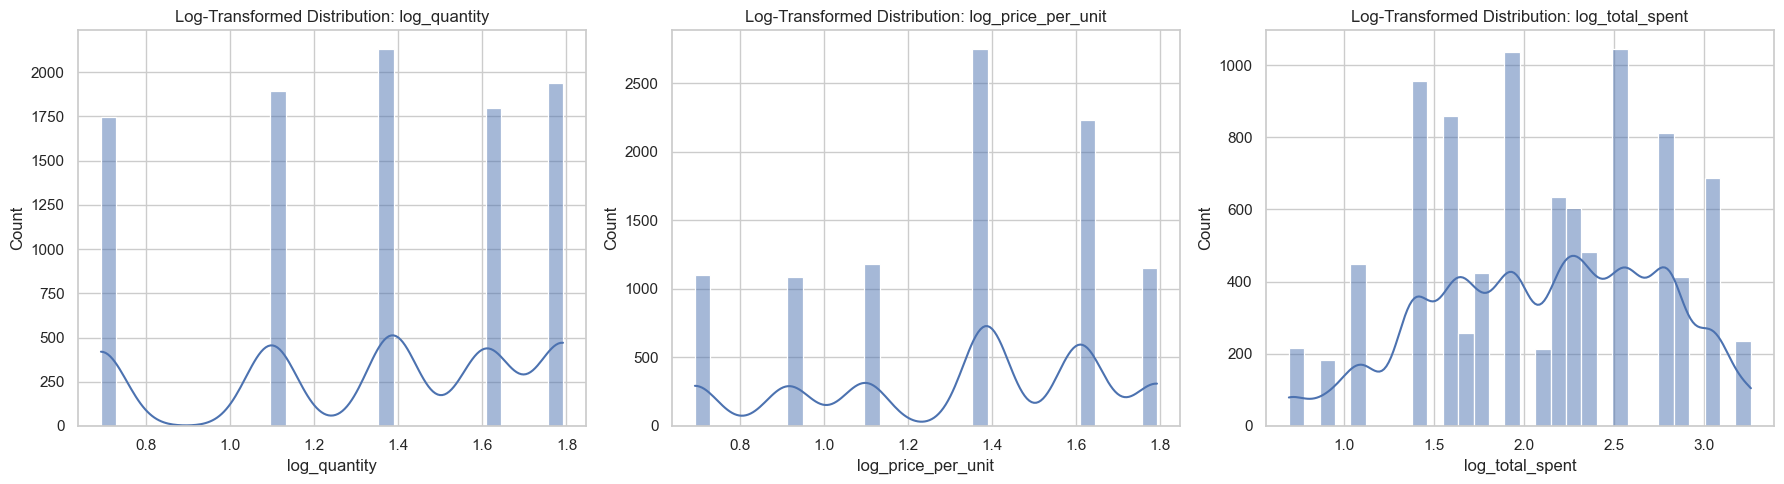

In [33]:
# Apply log1p transformation (handles zeros safely)
df['log_quantity'] = np.log1p(df['quantity'])
df['log_price_per_unit'] = np.log1p(df['price_per_unit'])
df['log_total_spent'] = np.log1p(df['total_spent'])

# Plot transformed distributions
log_cols = ['log_quantity', 'log_price_per_unit', 'log_total_spent']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(log_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Log-Transformed Distribution: {col}')

plt.tight_layout()
plt.show()

- The log-transformed distributions of all three features became more compact and symmetric, especially for total_spent, which was heavily right-skewed.
- This transformation improves model stability and makes the data more suitable for algorithms that assume normality.

##### Feature Encoding

Let's Encode Categorical Features for Modeling
- *Applied one-hot encoding to location and payment_method, and label encoding to item to convert categorical data into machine-readable format.*

In [ ]:
categorical_cols = ['location', 'payment_method', 'item']

# One-Hot Encoding (for location, payment_method if low cardinality)
df_encoded = pd.get_dummies(df, columns=['location', 'payment_method'], drop_first=True)

# Label Encoding (if you want to try tree-based models and avoid high-dim one-hot)
label_enc = LabelEncoder()
df_encoded['item_encoded'] = label_enc.fit_transform(df['item'])

df_encoded.head(10) # Display the first few rows of the encoded DataFrame

,transaction_id,item,quantity,price_per_unit,total_spent,transaction_date,total_spent_iqr_capped,day,month,weekday,is_weekend,total_price_check,log_quantity,log_price_per_unit,log_total_spent,location_Takeaway,payment_method_Credit Card,payment_method_Digital Wallet,item_encoded
0,TXN_1961373,Coffee,2,2.0,4.0,2023-09-08,4.0,8,9,Friday,False,4.0,1.098612,1.098612,1.609438,True,True,False,1
1,TXN_4977031,Cake,4,3.0,12.0,2023-05-16,12.0,16,5,Tuesday,False,12.0,1.609438,1.386294,2.564949,False,False,False,0
2,TXN_4271903,Cookie,4,1.0,4.0,2023-07-19,5.9,19,7,Wednesday,False,4.0,1.609438,0.693147,1.609438,False,True,False,2
3,TXN_7034554,Salad,2,5.0,10.0,2023-04-27,10.0,27,4,Thursday,False,10.0,1.098612,1.791759,2.397895,False,False,True,4
4,TXN_3160411,Coffee,2,2.0,4.0,2023-06-11,4.0,11,6,Sunday,True,4.0,1.098612,1.098612,1.609438,False,False,True,1
5,TXN_2602893,Smoothie,5,4.0,20.0,2023-03-31,20.0,31,3,Friday,False,20.0,1.791759,1.609438,3.044522,False,True,False,6
6,TXN_4433211,Juice,3,3.0,9.0,2023-10-06,9.0,6,10,Friday,False,9.0,1.386294,1.386294,2.302585,True,False,True,3
7,TXN_6699534,Sandwich,4,4.0,16.0,2023-10-28,16.0,28,10,Saturday,True,16.0,1.609438,1.609438,2.833213,False,False,False,5
8,TXN_4717867,Juice,5,3.0,15.0,2023-07-28,15.0,28,7,Friday,False,15.0,1.791759,1.386294,2.772589,True,False,True,3
9,TXN_2064365,Sandwich,5,4.0,20.0,2023-12-31,20.0,31,12,Sunday,True,20.0,1.791759,1.609438,3.044522,False,False,True,5


- One-hot encoding was used for low-cardinality features (location, payment_method), reducing redundancy by dropping the first category.
- Label encoding was applied to item, assigning each unique item a numeric code—efficient for tree-based models.
- These encodings ensure categorical variables are ready for modeling without introducing multicollinearity or dimensionality issues.

---

***Observation Set 4***

- **Created** time-based features (day, month, weekday, is_weekend) from transaction_date.
- **Validated** total_spent by calculating total_price_check; due to mismatch, the calculated value was used for reliability.
- **Transformed** skewed numerical features using log1p and PowerTransformer to improve distribution and model readiness.
- **Encoded** categorical columns: one-hot encoding for location and payment_method; label encoding for item to keep dimensions manageable.
- These steps enhanced the dataset’s analytical depth and prepared it for modeling.

---
---

### 5. Data Visualization

This phase focuses on turning raw data into meaningful visuals to reveal patterns, trends, and relationships that aren't immediately visible. By using various charts and plots, we aim to generate insights that support both business understanding and data-driven decision-making.

In this step, we explore:

📈 Sales Performance Overview

👥 Customer Behavior Patterns

⏱️ Time-Based Insights

📦 Product-Level Analysis

📍 Location-Wise Deep Dive

These visuals help communicate findings clearly to both technical and non-technical stakeholders, making complex insights easier to act on.



---


##### 📈 Sales Performance Overview


**Total Sales Trend Over Time** - *Show how total revenue changes over time (monthly) to identify seasonality, trends, or growth/decline.*

Line Plot - Monthly Revenue Trend

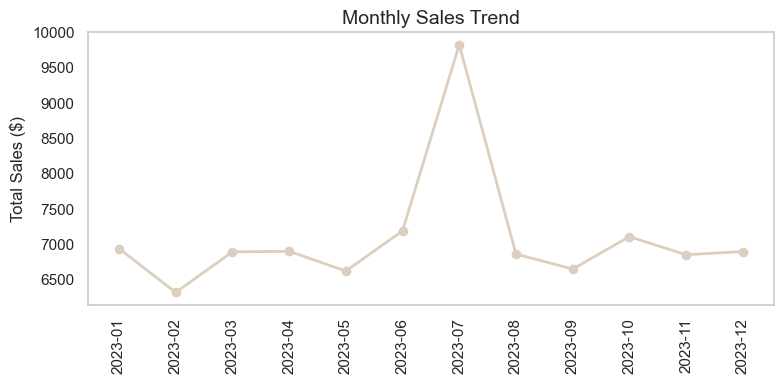

In [35]:
# Ensure 'date' is in datetime format
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Group by month and calculate total sales
df['month'] = df['transaction_date'].dt.to_period('M')
monthly_sales = df.groupby('month')['total_spent'].sum().reset_index()
monthly_sales['month'] = monthly_sales['month'].astype(str)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(monthly_sales['month'], monthly_sales['total_spent'], marker='o', color='#DCCFC0', linewidth=2)
plt.title('Monthly Sales Trend', fontsize=14)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(False) 
plt.tight_layout()
plt.show()

- Sales stayed fairly stable throughout the year—hovering between $6,500 and $7,200—until July, when they shot up dramatically to nearly $10,000. This sharp spike suggests a one-time event or campaign that worked exceptionally well. After July, sales returned to their usual range, reinforcing July as a key outlier worth investigating further.

--

**Top-Selling Items** - *Highlight which products bring in the most revenue — so managers know which items to promote, stock more, or feature in campaigns.*

Horizontal Bar Chart - Top 5 Items by Revenue

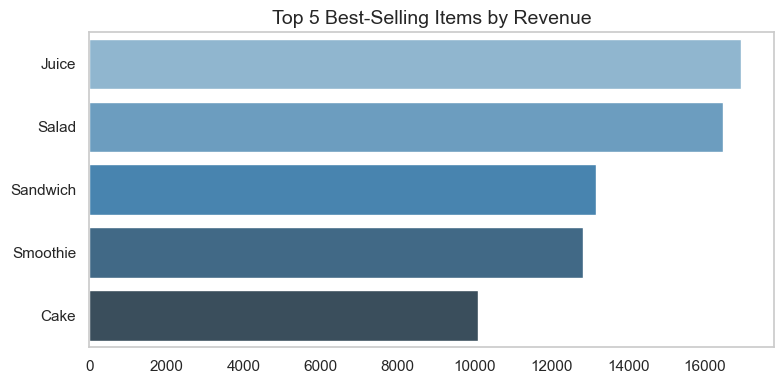

In [36]:
# Group by item and calculate total sales
top_items = df.groupby('item')['total_spent'].sum().sort_values(ascending=False).head(5).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_items,
    x='total_spent',
    y='item',
    hue='item',               # Required to safely use palette
    palette='Blues_d',
    dodge=False,
    legend=False              # Hides the legend since it's redundant
)
plt.title('Top 5 Best-Selling Items by Revenue', fontsize=14)
plt.xlabel("")  # Remove x-axis title
plt.ylabel("")  # Remove y-axis title
plt.grid(False)
plt.tight_layout()
plt.show()

- Here are the top 5 best-selling items by revenue. These are our most profitable products and should be prioritized in promotions and inventory planning.

---

##### 👥 Customer Behavior Patterns

**Sales by Payment Method** - *Understand customer preferences: Are they using cash, card, or digital wallets? This can help in POS upgrades or payment-related offers.*

Donut Chart - Payment Method Breakdown

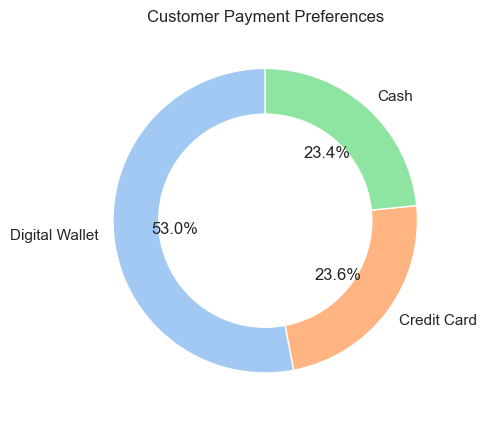

In [37]:
# Group by payment method
payment_data = df['payment_method'].value_counts()

# Plot
plt.figure(figsize=(5, 5))
colors = sns.color_palette('pastel')[0:len(payment_data)]

# Donut chart
plt.pie(payment_data, labels=payment_data.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Customer Payment Preferences', fontsize=12)
plt.tight_layout()
plt.show()


- The majority of customers prefer Digital Wallet, while a smaller segment still uses cash. This tells us our digital payment systems are widely adopted — we could consider incentives like cashback for digital modes to further increase usage.

--

**Price vs Quantity Purchased** - *Reveal whether customers tend to buy more of cheaper items — i.e., price sensitivity or volume-driven demand.*

Scatter Plot - Price vs Quantity

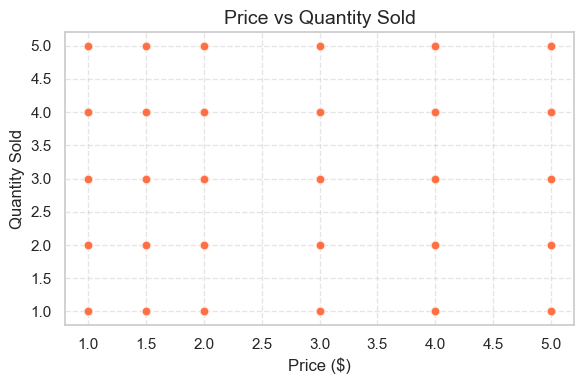

In [38]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='price_per_unit', y='quantity', alpha=0.6, color='#FF7043')
plt.title('Price vs Quantity Sold', fontsize=14)
plt.xlabel('Price ($)')
plt.ylabel('Quantity Sold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- The scatter plot shows a uniform spread, meaning quantity sold doesn’t visibly increase or decrease with price. This suggests no strong correlation between pricing and purchase volume—either due to data limitations or evenly distributed product types. It may be worth digging deeper into product categories or customer segments for more targeted pricing insights.

---

##### ⏱️ Time-Based Insights

**Day-of-Week Performance** - *Identify which days of the week drive the most sales.*

Bar Plot - Sales by Day

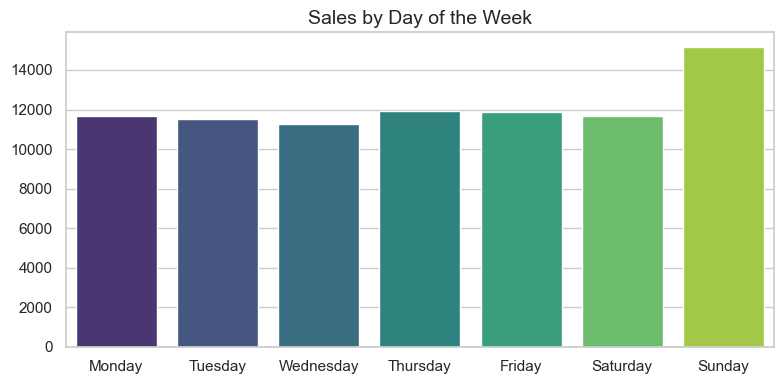

In [39]:
# Create 'day_of_week' column
df['day_of_week'] = df['transaction_date'].dt.day_name()

# Group and order days
dow_sales = df.groupby('day_of_week')['total_spent'].sum()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = dow_sales.reindex(day_order).reset_index()

# Rename columns for clarity
dow_sales.columns = ['day_of_week', 'total_sales']

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(
    data=dow_sales,
    x='day_of_week',
    y='total_sales',
    hue='day_of_week',        # Add hue to safely use palette
    palette='viridis',
    legend=False              # Hide legend (optional)
)
plt.title('Sales by Day of the Week', fontsize=14)
plt.xlabel('')               # Remove x-axis label
plt.ylabel('')               # Remove y-axis label
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- Weekends — especially Saturday and Sunday — see the highest traffic. This aligns with leisure visits. We can test weekend-only specials or event-based promotions to capitalize on this trend.

--

**Monthly Revenue Breakdown** - *Combine monthly sales and item volume to understand both revenue and product movement.*

Dual-Axis Chart - Revenue vs Quantity by Month

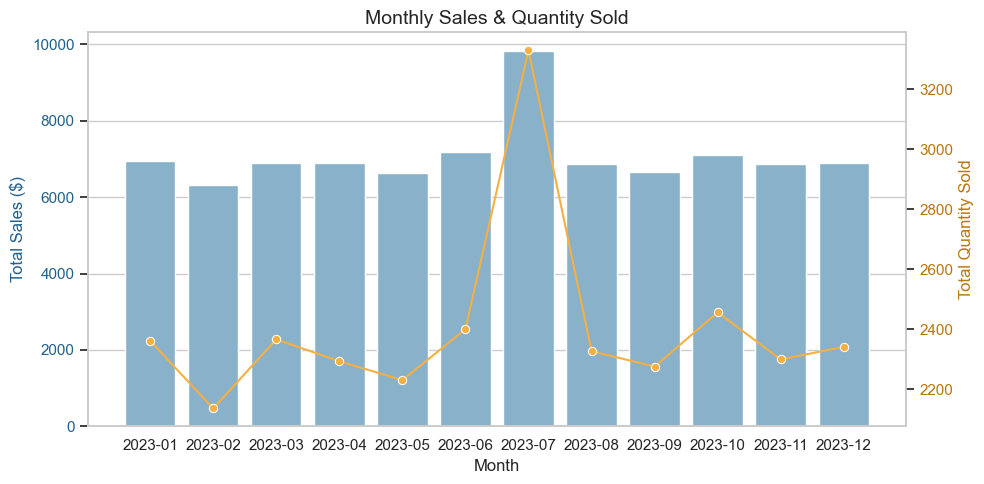

In [40]:
# Monthly item volume and revenue
monthly_stats = df.groupby('month').agg({
    'total_spent': 'sum',
    'quantity': 'sum'
}).reset_index()

# Convert 'month' to string for plot labels
monthly_stats['month'] = monthly_stats['month'].astype(str)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Revenue (bar)
sns.barplot(x='month', y='total_spent', data=monthly_stats, ax=ax1, color='#7FB3D5')
ax1.set_ylabel('Total Sales ($)', color='#1F618D')
ax1.set_xlabel('Month')
ax1.tick_params(axis='y', labelcolor='#1F618D')

# Quantity (line)
ax2 = ax1.twinx()
sns.lineplot(x='month', y='quantity', data=monthly_stats, ax=ax2, color='#F5B041', marker='o')
ax2.set_ylabel('Total Quantity Sold', color='#B9770E')
ax2.tick_params(axis='y', labelcolor='#B9770E')

plt.title('Monthly Sales & Quantity Sold', fontsize=14)
plt.xticks(rotation=45)
plt.grid(False)  # Disable grid for clarity
plt.tight_layout()
plt.show()


- In July 2023, something big happened—sales and quantity sold both surged to their highest point of the year. It was likely due to a major event like a sale or campaign. Before and after that spike, sales stayed steady, but the number of items sold fluctuated more, hinting at pricing changes or shifting demand. July was clearly a standout moment in an otherwise consistent year.

---

##### 📦 Product-Level Analysis

**Top 5 Items by Quantity Sold** - *Spot the most frequently purchased items — helps with inventory planning and demand forecasting.*

Horizontal Bar Chart - Quantity-Based Ranking

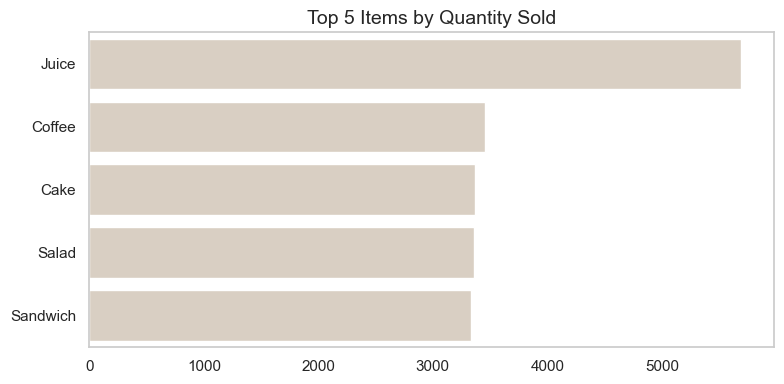

In [41]:
# Group by item and sum quantity
top_items_qty = df.groupby('item')['quantity'].sum().sort_values(ascending=False).head(5)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=top_items_qty.values, y=top_items_qty.index, color='#DCCFC0')
plt.title('Top 5 Items by Quantity Sold', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.grid(False)  # Disable grid for clarity
plt.tight_layout()
plt.show()


- These are our most popular items in terms of volume. While some may not bring in the highest revenue, they drive footfall and could be bundled with high-margin products to boost profit.

--

**Price vs Quantity** - *Reveal patterns across price levels and volume sold — ideal for evaluating pricing strategies.*

Heatmap - Price Ranges vs Volume

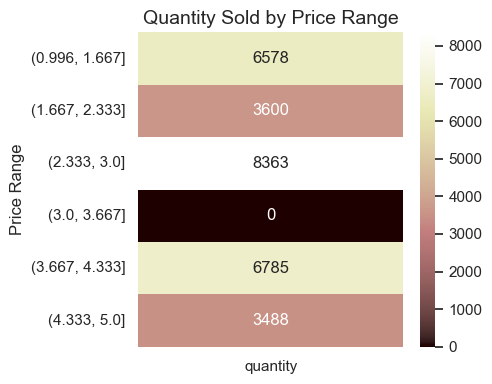

In [42]:
# Create price bins
df['price_bin'] = pd.cut(df['price_per_unit'], bins=6)

# Group and pivot with observed=False to silence warning
heatmap_data = df.groupby('price_bin', observed=False)['quantity'].sum().reset_index()
heatmap_pivot = heatmap_data.pivot_table(
    values='quantity',
    index='price_bin',
    aggfunc='sum',
    observed=False
)

# Plot
plt.figure(figsize=(5, 4))  # Adjust width for a single column heatmap
sns.heatmap(heatmap_pivot, annot=True, fmt='g', cmap='pink', cbar=True)
plt.title('Quantity Sold by Price Range', fontsize=14)
plt.xlabel('')
plt.ylabel('Price Range')
plt.tight_layout()
plt.show()


- Most sales happened when prices were between ₹2.33 and ₹3.00, showing strong customer preference for mid-range pricing. Interestingly, no sales at all occurred in the ₹3.00–₹3.66 range possibly due to unattractive pricing or a missing product tier. Both lower and higher price ranges had decent sales, but the sweet spot is clearly in the mid-range. This is a strong signal for pricing strategy and product positioning.

---

##### 📍 Location-Wise Deep Dive

**Sales Trend by Location** - *Track each cafe’s monthly performance — spot underperformers or growth stars.*

Multi-Line Plot - Location-wise Monthly Revenue

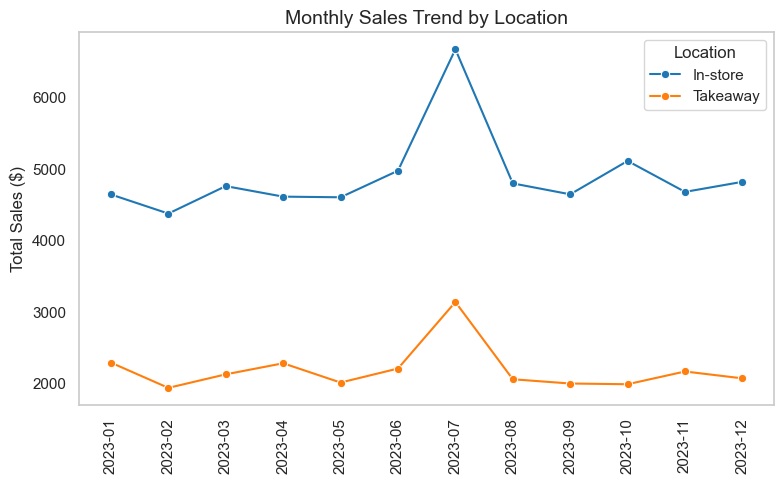

In [43]:
# Group by month and location
location_trend = df.groupby(['month', 'location'])['total_spent'].sum().reset_index()

# Convert 'month' to string for x-axis
location_trend['month'] = location_trend['month'].astype(str)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=location_trend, x='month', y='total_spent', hue='location', marker='o', palette='tab10')
plt.title('Monthly Sales Trend by Location', fontsize=14)
plt.xlabel('')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=90)
plt.grid(False)  # Disable grid for clarity
plt.tight_layout()
plt.legend(title='Location')
plt.show()

- In-store sales were consistently stronger throughout the year, peaking sharply in July—suggesting a successful in-store event or seasonal boost. Takeaway followed a similar pattern but at a lower scale, with its own July spike, likely riding the same wave of demand. Both channels returned to normal after July, highlighting it as a unique opportunity that’s worth replicating.

--

**Payment Method Preference by Location** - *Understand regional differences in how customers prefer to pay.*

Stacked Bar Chart - Payment Method Distribution

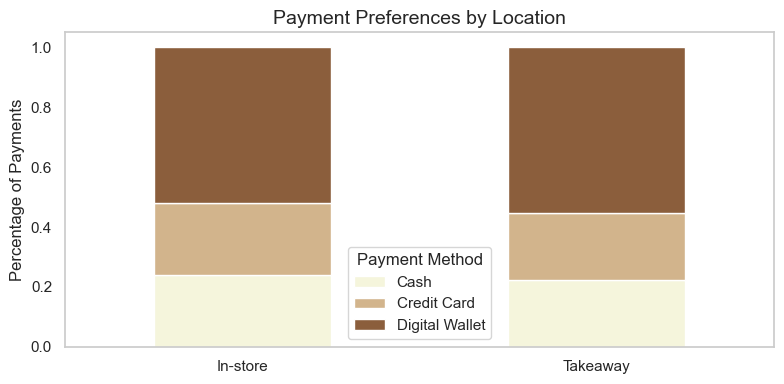

In [48]:
# Group and normalize payment method per location
pay_loc = df.groupby(['location', 'payment_method']).size().unstack().fillna(0)

# Normalize to get percentage share per location
pay_loc_pct = pay_loc.div(pay_loc.sum(axis=1), axis=0)

# Plot
pay_loc_pct.plot(kind='bar', stacked=True, figsize=(8, 4), colormap=tan_brown_cmap)
plt.title('Payment Preferences by Location', fontsize=14)
plt.ylabel('Percentage of Payments')
plt.xlabel('')
plt.legend(title='Payment Method')
plt.xticks(rotation=0)
plt.grid(False)  # Disable grid for clarity
plt.tight_layout()
plt.show()

- In-store sales consistently outperformed takeaway, with a big peak in July—possibly due to in-store events or promotions. Takeaway also spiked that month, suggesting strong overall demand.

- When it comes to how people pay, Digital Wallets lead the way in both formats. However, in-store customers use more credit cards, while cash and wallets dominate takeaway orders. This could guide location-specific payment strategies and offers.

---
---

### 6. Final Business Recommendations - Cafe Sales Analysis

1. Focus on Best-Selling Items

    - Certain products consistently dominate sales volume across locations.

    - Recommendation - Promote these top items through combo deals, loyalty programs, or seasonal campaigns to boost repeat purchases.


2. Optimize Inventory by Location

    - Some café branches show significantly higher transaction volumes.

    - Recommendation - Adjust inventory and staff allocation based on location-level performance. Consider scaling up high-performing locations or revisiting underperforming ones.


3. Leverage Payment Preferences

    - A clear dominance of certain payment methods (e.g., digital wallets or credit cards) is observed.

    - Recommendation - Ensure seamless support for preferred payment methods and incentivize digital payments via cashback or discounts.


4. Utilize Time-Based Sales Trends

    - Weekends and certain days show spikes in sales, especially for specific items.

    - Recommendation - Launch weekend-specific offers or promotions, and adjust staff schedules to handle peak times.


5. Understand Customer Behavior Patterns

    - Quantity and total spending are positively correlated, especially with high-value items.

    - Recommendation - Encourage bulk buying by offering quantity-based discounts or “Buy 2 Get 1 Free” deals.


6. Maintain Clean Data Practices

    - Data inconsistencies like EERROR, UNKNOWN, and mismatched entries were present.

    - Recommendation - Improve front-end data capture systems at POS (Point-of-Sale) to reduce manual errors and ensure reliable reporting.
    

7. Monitor Outliers & Fraud

    - Outliers in total_spent may represent bulk purchases or errors.

    - Recommendation - Set up automatic anomaly detection to flag transactions significantly outside the norm for review.

---
---


***By the end of this project, you’ll not only see how raw sales data becomes decision-grade intelligence, but also how structured EDA reveals real-world business insights — the kind that help cafés increase efficiency, improve sales strategies, and understand their customers better.***